In [21]:
#%pip install tfds-nightly
#%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (10, 5)})

In [22]:
df = pd.read_csv("data.csv")

In [23]:
# Cell 3: parse created_date which may be bytes (e.g., b'2016-11-29 ...')
def parse_created_date(val):
    # decode bytes if needed and coerce to datetime (UTC)
    if isinstance(val, (bytes, bytearray)):
        s = val.decode("utf-8")
    else:
        s = str(val)
    # Some entries may already be 'YYYY-MM-DD ...' strings; this will handle them
    return pd.to_datetime(s, errors="coerce", utc=True)

# Apply parsing
df["created_date"] = df["created_date"].apply(parse_created_date)

# Drop rows with invalid dates
df = df.dropna(subset=["created_date"]).reset_index(drop=True)

# Quick sanity
print("Rows with valid dates:", len(df))

Rows with valid dates: 1999516


In [24]:
# Cell 4: assign class and extract year
df["class"] = df["toxicity"].apply(lambda t: "Hate" if t > 0.5 else "Non-Hate")
df["month"] = df["created_date"].dt.to_period("M")

print("Class counts:")
print(df["class"].value_counts())


Class counts:
Non-Hate    1881641
Hate         117875
Name: class, dtype: int64


c:\Users\Dario\miniconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


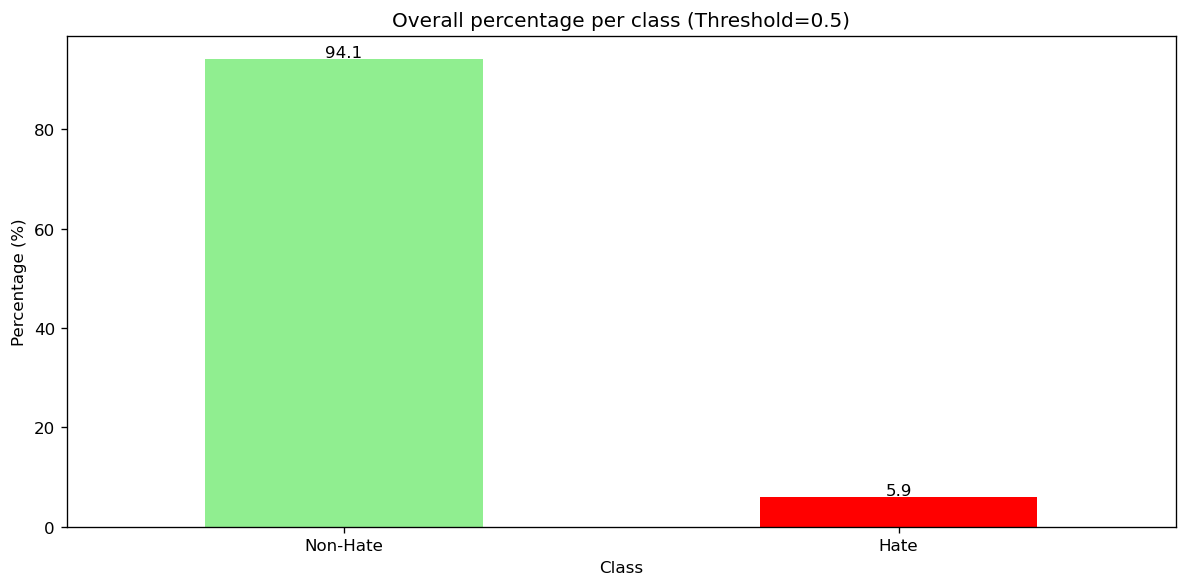

In [11]:
# Cell 5: overall percentage of the two classes
class_percent = df["class"].value_counts(normalize=True).reindex(["Non-Hate","Hate"]).fillna(0) * 100
colors = {"Hate":"red", "Non-Hate":"lightgreen"}

plt.figure()
class_percent.plot(kind="bar", color=[colors[c] for c in class_percent.index])
plt.title("Overall percentage per class (Threshold=0.5)")
plt.ylabel("Percentage (%)")
plt.xlabel("Class")
plt.xticks(rotation=0)
for i, v in enumerate(class_percent):
    plt.text(i, v + 0.5, f"{v:.1f}", ha="center")
plt.tight_layout()
plt.show()

class,Hate,Non-Hate
month,,
2015-09,21,461
2015-10,26,364
2015-11,0,46
2015-12,0,54
2016-01,37,886


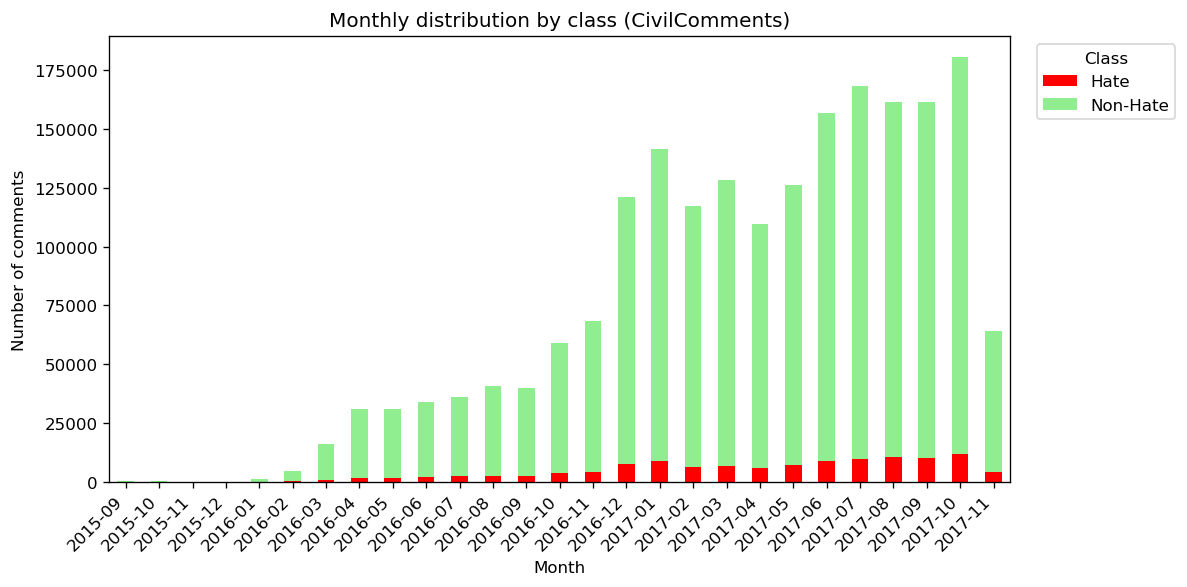

In [16]:
# Cell 6: yearly counts and stacked bar (each year shows counts per class)
monthly_counts = df.groupby(["month", "class"]).size().unstack(fill_value=0).sort_index()
display(monthly_counts.head())

# Plot stacked bar
monthly_counts.plot(kind="bar", stacked=True, color=[colors.get(c) for c in monthly_counts.columns])
plt.title("Monthly distribution by class (CivilComments)")
plt.xlabel("Month")
plt.ylabel("Number of comments")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


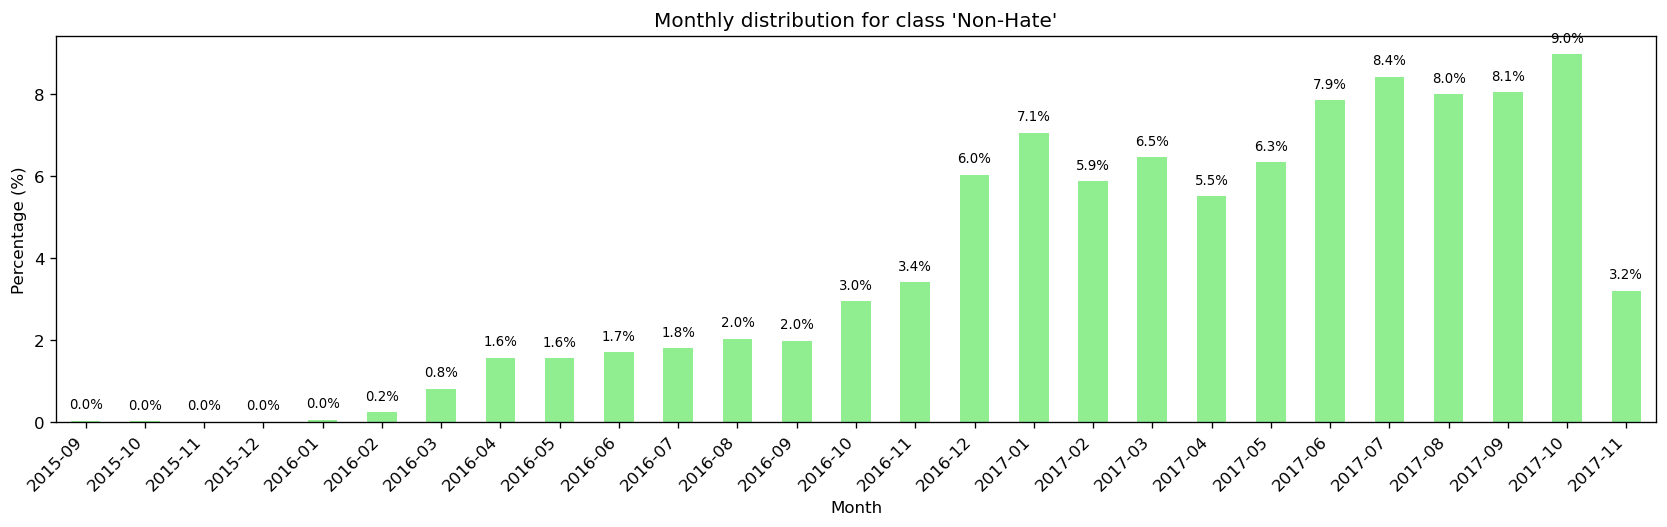

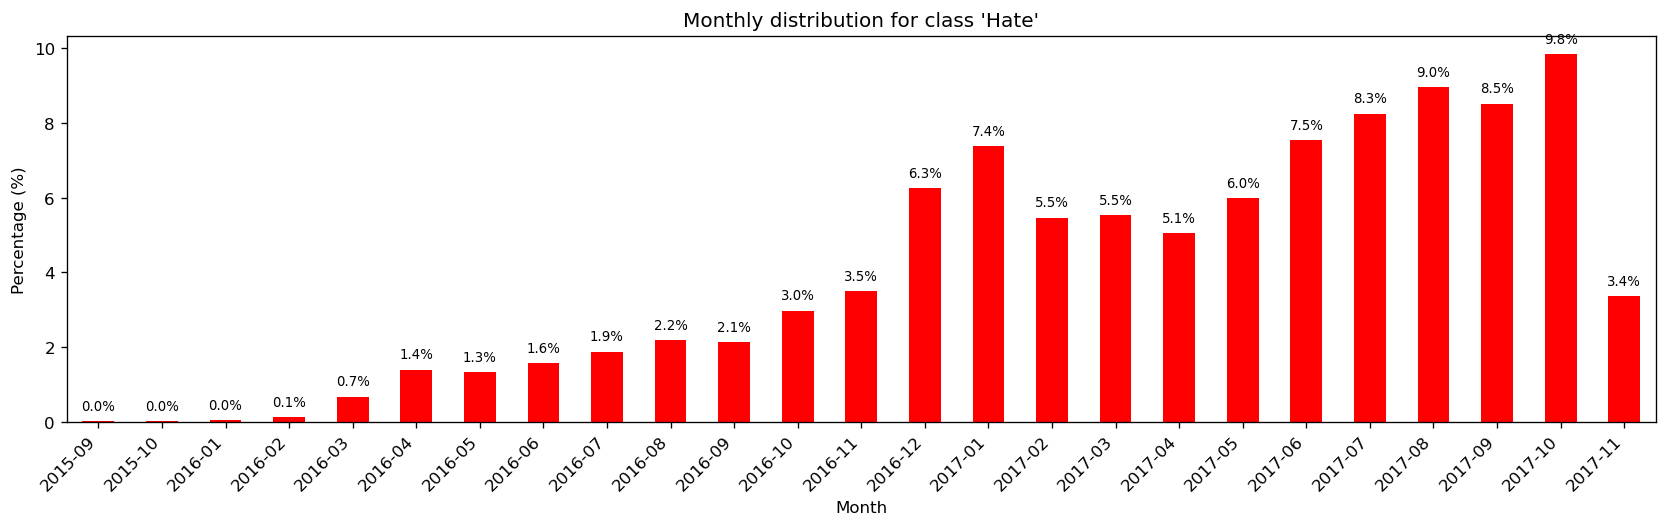

In [18]:
# Cell 9: for each class, weekly distribution as percentage of that class total
for cls in ["Non-Hate", "Hate"]:
    df_cls = df[df["class"] == cls]
    if df_cls.empty:
        continue
    counts_per_week = df_cls.groupby("month").size().sort_index()
    percent_per_week = counts_per_week / counts_per_week.sum() * 100

    plt.figure(figsize=(14,4.5))
    percent_per_week.plot(kind="bar", color=colors[cls])
    plt.title(f"Monthly distribution for class '{cls}'")
    plt.xlabel("Month")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45, ha="right")
    for i, val in enumerate(percent_per_week):
        plt.text(i, val + 0.3, f"{val:.1f}%", ha="center", fontsize=8)
    plt.tight_layout()
    plt.show()


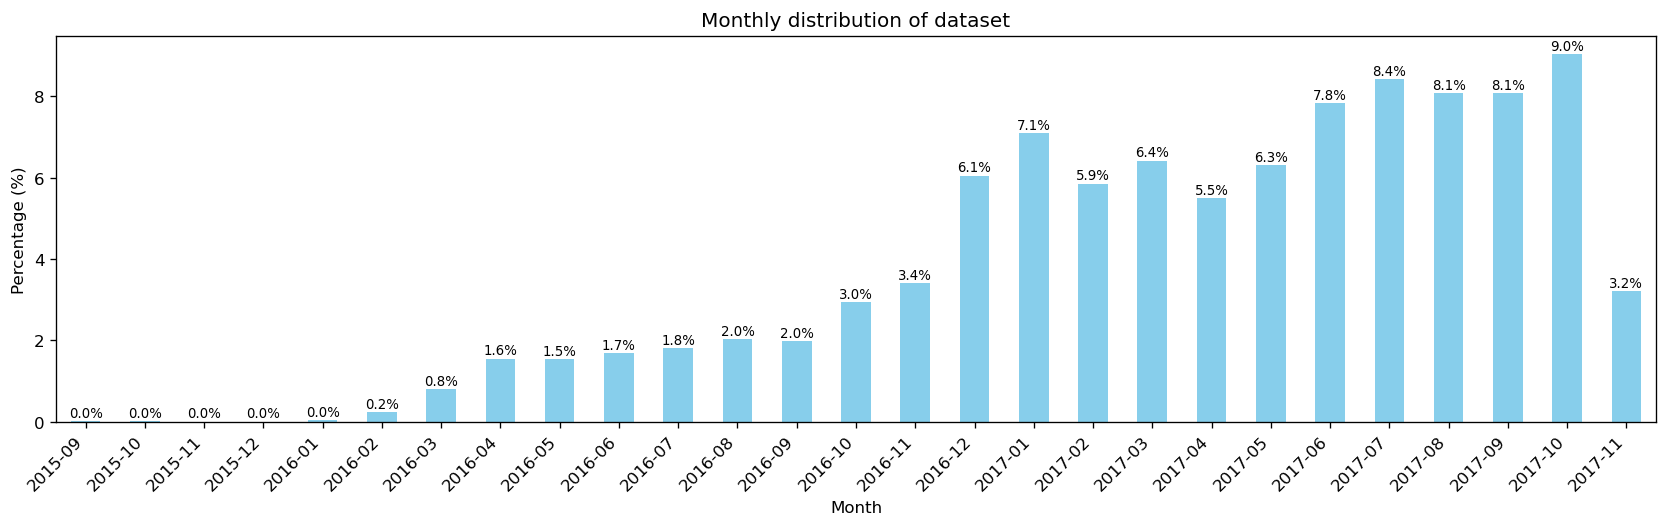

In [20]:
# Cell 10: monthly distribution ignoring class
monthly_totals = monthly_counts.sum(axis=1)
monthly_percent_all = monthly_totals / monthly_totals.sum() * 100

plt.figure(figsize=(14,4.5))
monthly_percent_all.plot(kind="bar", color="skyblue")
plt.title("Monthly distribution of dataset")
plt.xlabel("Month")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
for i, val in enumerate(monthly_percent_all):
    plt.text(i, val + 0.1, f"{val:.1f}%", ha="center", fontsize=8)
plt.tight_layout()
plt.show()


Targets Distribution

In [85]:
hate_df = df[df["class"] == "Hate"].copy()

cols = hate_df.columns[21:-4] # targets labels
hate_df["target"] = hate_df[cols].idxmax(axis=1)



# Remove the invalid rows
hate_df = hate_df.dropna(subset=["target"]) 
hate_df["target"][hate_df[hate_df.iloc[:, 21:-4].sum(axis=1) == 0].index] = "Others"

print(f"New row number: {len(hate_df)}")

New row number: 36000


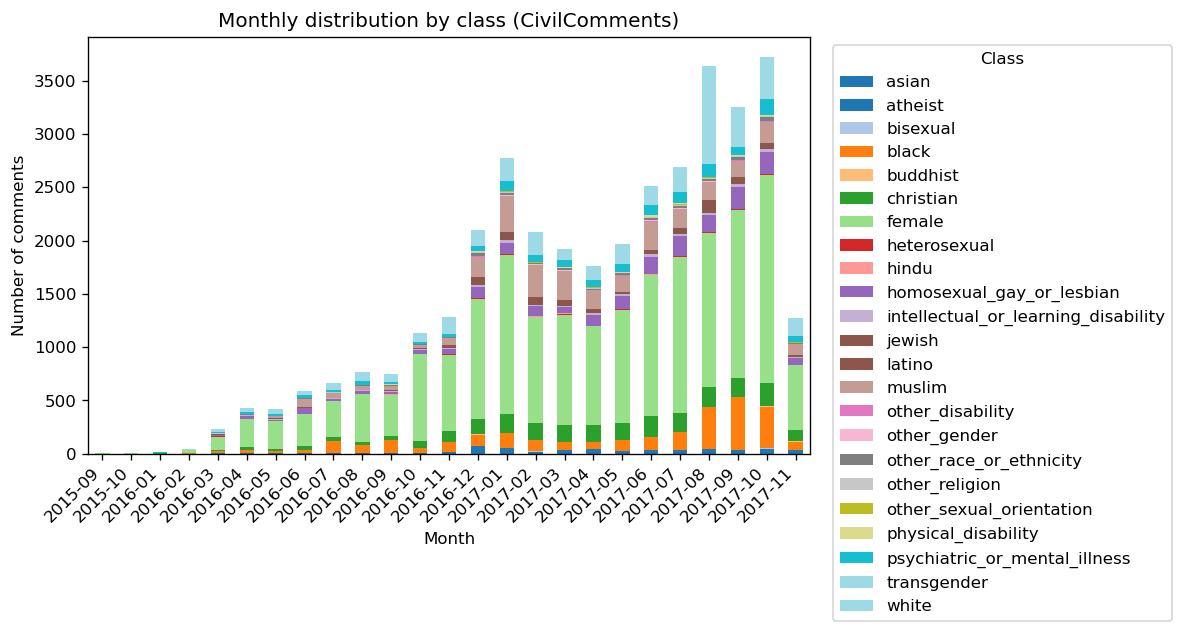

In [86]:
monthly_counts = hate_df.groupby(["month", "target"]).size().unstack(fill_value=0).sort_index()

# Plot stacked bar
monthly_counts.plot(kind="bar", stacked=True, colormap=plt.get_cmap("tab20"))
plt.title("Monthly distribution by class (CivilComments)")
plt.xlabel("Month")
plt.ylabel("Number of comments")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


In [94]:
hate_df["comment_text"][hate_df["target"] == "female"].head(n=20).tolist()

["Blame men.  There's always an excuse to blame men for the failures of women.",
 'And the woman exposing herself saying grab this pussy is an offer I take? She definitely is the sane and high class American that you gloat about trying to represent',
 "You have no business making any comments on this site, Craig.  For all the  bigot and racists comments that you've personally posted on this site against rural Alaska Natives, the homeless, and the LGBT community, you should be banned from this site.  Alaska and the nation don't need your kind breathing our air.  No.  It's not time to move on.  Every time you rear your bigot, racist head, I'll be  there to call you down and so should everyone else that is exposed to your garbage.",
 'I guess the issue is people not willing to put up with the stupid charade of pretending they are willing to live as brother and sister.',
 'JackJohnson5:\n"And they say Trump supporters are uneducated!"\n\n-\n\nNo, not necessarily uneducated, just too emotio